In [8]:
import torch 
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torchvision
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import math 
import time 
import os
import yaml

# Global Variable

In [ ]:
# data
path_data = 'D:/data/shiyan/' ### 'D:/data/cheng_da_normal/' ### 
device = T.device("cuda:0" if (T.cuda.is_available()) else "cpu")
# categories = [line.replace("\n","") for line in open(path_data + "label_list.txt").readlines()]
categories = ['foreign']
num_class = len(categories)
name2id = dict(zip(categories, range(num_class)))
id2name = dict(zip(range(num_class), categories))
image_size = 512 ### 640
# anchors = T.tensor([[[ 10.,  13.],
#                      [ 16.,  30.],
#                      [ 33.,  23.]],

#                     [[ 30.,  61.],
#                      [ 62.,  45.],
#                      [ 59., 119.]],

#                     [[116.,  90.],
#                      [156., 198.],
#                      [373., 326.]]], device=device, dtype=T.float32)
anchors = T.tensor([[[ 4.,   4.],
                     [ 6.,   6.],
                     [ 8.,   8.]],

                    [[ 8.,   8.],
                     [ 12., 12.],
                     [ 16., 16.]],

                    [[16.,  16.],
                     [32.,  32.],
                     [64.,  64.]]], device=device, dtype=T.float32)
stride = T.tensor([8., 16., 32.], device=device, dtype=T.float32)
num_anchor = len(anchors)
num_workers = 0

# model
channel = 32
scale = 32

# training
batch_size = 8
epochs = 200000 # 200
learning_rate = 1e-4
label_smoothing = 0.0
box = 0.05  # box loss gain
cls = 0.5  # cls loss gain
cls_pw = 1.0  # cls BCELoss positive_weight
obj = 1.0  # obj loss gain (scale with pixels)
obj_pw = 1.0  # obj BCELoss positive_weight
anchor_t = 4.0  # anchor-multiple threshold
fl_gamma = 0.0  # focal loss gamma (efficientDet default gamma=1.5)

#
path_work = 'D:/model/yolow/'
if not os.path.exists(path_work):
    os.makedirs(path_work)

In [17]:
with open('D:/BaiduSyncdisk/gitclone/yolov5v7.0/models/yolov5s.yaml', encoding='ascii', errors='ignore') as f:
    yaml_ = yaml.safe_load(f)  # model dict

In [18]:
print(yaml_)

{'nc': 80, 'depth_multiple': 0.33, 'width_multiple': 0.5, 'anchors': [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], 'backbone': [[-1, 1, 'Conv', [64, 6, 2, 2]], [-1, 1, 'Conv', [128, 3, 2]], [-1, 3, 'C3', [128]], [-1, 1, 'Conv', [256, 3, 2]], [-1, 6, 'C3', [256]], [-1, 1, 'Conv', [512, 3, 2]], [-1, 9, 'C3', [512]], [-1, 1, 'Conv', [1024, 3, 2]], [-1, 3, 'C3', [1024]], [-1, 1, 'SPPF', [1024, 5]]], 'head': [[-1, 1, 'Conv', [512, 1, 1]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 6], 1, 'Concat', [1]], [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [256, 1, 1]], [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']], [[-1, 4], 1, 'Concat', [1]], [-1, 3, 'C3', [256, False]], [-1, 1, 'Conv', [256, 3, 2]], [[-1, 14], 1, 'Concat', [1]], [-1, 3, 'C3', [512, False]], [-1, 1, 'Conv', [512, 3, 2]], [[-1, 10], 1, 'Concat', [1]], [-1, 3, 'C3', [1024, False]], [[17, 20, 23], 1, 'Detect', ['nc', 'anchors']]]}


In [21]:
ch = yaml_.get('ch', 6)
ch

6

In [13]:
ch = yaml_['ch'] = yaml_.get('ch', 3)
ch

3

In [22]:
a = eval(None)

TypeError: eval() arg 1 must be a string, bytes or code object

# Data 

In [ ]:
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = w * (x[..., 0] - x[..., 2] / 2) + padw  # top left x
    y[..., 1] = h * (x[..., 1] - x[..., 3] / 2) + padh  # top left y
    y[..., 2] = w * (x[..., 0] + x[..., 2] / 2) + padw  # bottom right x
    y[..., 3] = h * (x[..., 1] + x[..., 3] / 2) + padh  # bottom right y
    return y


def xyxy2xywhn(x, w=640, h=640, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = ((x[..., 0] + x[..., 2]) / 2) / w  # x center
    y[..., 1] = ((x[..., 1] + x[..., 3]) / 2) / h  # y center
    y[..., 2] = (x[..., 2] - x[..., 0]) / w  # width
    y[..., 3] = (x[..., 3] - x[..., 1]) / h  # height
    return y


def xywh2xyxy(xywh):
    xyxy = xywh.clone() if isinstance(xywh, T.Tensor) else xywh.copy()
    xyxy[...,0] = xywh[...,0] - xywh[...,2]/2
    xyxy[...,1] = xywh[...,1] - xywh[...,3]/2
    xyxy[...,2] = xywh[...,0] + xywh[...,2]/2
    xyxy[...,3] = xywh[...,1] + xywh[...,3]/2
    return xyxy

In [ ]:
# class LoadImagesAndLabels(Dataset):
#     #
#     def __init__(self,
#                  path=path_data,
#                  img_size=512,
#                  cache_images=True,
#                  cache_foreign=True,
#                  epoch=0):
        
#         self.img_size = img_size
#         self.path = path
#         self.cache_images = cache_images
#         self.epoch = epoch

#         # 产品图
#         self.path_background = path
#         self.path_image_background = self.path_background + 'data/images/' 
#         self.list_image_background = os.listdir(self.path_image_background) 
#         n = len(self.list_image_background)
#         if self.cache_images:
#             self.path_npy_background = self.path_background + 'data/npys/'
#             self.list_npy_background = os.listdir(self.path_npy_background) 

#         # 异物图
#         self.cache_foreign = cache_foreign ###
#         self.path_foreign = 'D:/data/foreign/' 
#         self.path_image_foreign = self.path_foreign + 'data/images/' 
#         self.list_image_foreign = os.listdir(self.path_image_foreign)
#         self.num_foreign = len(self.list_image_foreign)
#         if self.cache_foreign:
#             self.path_npy_foreign = self.path_foreign + 'data/npys/'
#             self.list_npy_foreign = os.listdir(self.path_npy_foreign) 

#         # Create indices
#         self.indices = range(n)
    
#     def rotate(self, image, borderValue):
#         h, w = image.shape[:2]
#         angle = np.random.uniform(low=0, high=360)
#         M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
#         cos = np.abs(M[0, 0])
#         sin = np.abs(M[0, 1])
#         w_new = h * sin + w * cos
#         h_new = h * cos + w * sin
#         M[0, 2] += (w_new - w) * 0.5
#         M[1, 2] += (h_new - h) * 0.5
#         w_new = int(np.round(w_new))
#         h_new = int(np.round(h_new))
#         image = cv2.warpAffine(src=image, M=M, dsize=(w_new,h_new), borderValue=borderValue)
#         return image

#     def crop_background(self, image):
#         h, w = image.shape[:2]
#         h_random = np.random.randint(self.img_size, h+1)
#         w_random = np.random.randint(self.img_size, w+1)
#         y_random = np.random.randint(h-h_random+1)
#         x_random = np.random.randint(w-w_random+1)
#         image = image[y_random:y_random+h_random, x_random:x_random+w_random] 
#         return image
    
#     def crop_foreign(self, image):
#         indices = np.where(image >= 127)
#         h1 = indices[0].min()
#         h2 = indices[0].max()
#         w1 = indices[1].min()
#         w2 = indices[1].max()
#         image = image[h1:h2+1, w1:w2+1]
#         return image

#     def paste(self, image_background, image_foreign):
#         #
#         h1, w1 = image_background.shape[:2]
#         h2, w2 = image_foreign.shape[:2]
#         y_random = np.random.randint(h1-h2+1)
#         x_random = np.random.randint(w1-w2+1)
#         #
#         image_background_roi = image_background[y_random:y_random+h2, x_random:x_random+w2]
#         if image_background_roi.astype('float32').mean() >= 245 and self.epoch >= 1000:
#             return image_background, None
#         #
#         image_foreign = 255 - image_foreign
#         #
#         mask = (image_foreign.astype('float32') < image_background_roi.astype('float32'))
#         if not mask.any():
#             return image_background, None
#         if mask.mean()<=0.5 and image_foreign.size<=4:
#             return image_background, None
#         # if image_foreign[mask].astype('float32').mean() > 127:
#         #     return image_background, None
#         if image_foreign[mask].astype('float32').min() > (image_background_roi[1-mask].astype('float32').min() - 20):
#             return image_background, None
#         if image_foreign[mask].astype('float32').mean() > (image_background_roi[1-mask].astype('float32').mean() - 20):
#             return image_background, None
#         if image_foreign[mask].astype('float32').mean() > (image_background_roi.astype('float32').mean() - 20):
#             return image_background, None
#         # print(image_foreign)
#         # print(image_background_roi)
#         # print(mask)
#         # print('=====')
#         #
#         image_foreign = image_foreign * mask + image_background_roi * (1-mask)
#         #
#         alpha = np.random.uniform(low=0, high=0.9)
#         image_background_roi = image_foreign * (1-alpha) + image_background_roi * alpha
#         image_background[y_random:y_random+h2, x_random:x_random+w2] = image_background_roi
#         #
#         xc = x_random + w2 / 2 - 0.5
#         yc = y_random + h2 / 2 - 0.5
#         # label = [0, xc/w1, yc/h1, (w2+10)/w1, (h2+10)/h1]
#         label = [0, xc/w1, yc/h1, w2/w1, h2/h1]
#         return image_background, label

#     def paste_foreign_to_background(self, image_background):
#         #
#         if np.random.randint(2):
#             image_background = image_background[:, ::-1]
#         image_background = self.rotate(image_background, 255)
#         image_background = self.crop_background(image_background)
#         # image_background = cv2.resize(image_background, [self.img_size, self.img_size], cv2.INTER_AREA)
#         #
#         labels = []
#         # for _ in range(np.random.randint(10, 30+1)):
#         for _ in range(30):
#             try:
#                 id_foreign = np.random.randint(self.num_foreign) 
#                 if self.cache_foreign:
#                     image_foreign = np.load(self.path_npy_foreign + self.list_npy_foreign[id_foreign])
#                 else:
#                     image_foreign = cv2.imread(self.path_image_foreign + self.list_image_foreign[id_foreign], cv2.IMREAD_GRAYSCALE)
#                 # if np.random.randint(2):
#                     # image_foreign = cv2.dilate(image_foreign, np.ones(np.random.randint(1,6,2), np.uint8), iterations=1)
#                     # image_foreign = cv2.erode(image_foreign, np.ones(np.random.randint(1,6,2), np.uint8), iterations=1)
#                 if np.random.randint(2):
#                     image_foreign = image_foreign[:, ::-1]
#                 if np.random.randint(2):
#                     image_foreign = self.rotate(image_foreign, 0)
#                 if np.random.randint(2):
#                     image_foreign = self.crop_foreign(image_foreign)
#                 #
#                 # t = np.random.randint(100)
#                 # if t < 90:
#                 #     low_random = 2
#                 #     high_random = 9
#                 # elif t < 98:
#                 #     low_random = 8
#                 #     high_random = 65
#                 # else:
#                 #     low_random = 64
#                 #     high_random = 257
#                 low_random = 1
#                 high_random = 5
#                 w = np.random.randint(low_random, high_random)
#                 if np.random.randint(2):
#                     h = w 
#                 else:
#                     h = np.random.randint(low_random, high_random)
#                 image_foreign = cv2.resize(image_foreign, (w,h), interpolation=cv2.INTER_LINEAR)
#                 #
#                 image_background, label = self.paste(image_background, image_foreign)
#                 if label is not None:
#                     labels.append(label)
#             except:
#                 with open('D:/data/foreign/error/' + str(id_foreign) + '.txt', 'w') as f:
#                     f.write(str(id_foreign))
#                 continue
#         if np.random.randint(2):
#             image_background = cv2.GaussianBlur(image_background, (3,3), 0)
#         # image_background = cv2.GaussianBlur(image_background, (3,3), 0)
#         # image_background = cv2.blur(image_background, (3,3))
#         image_background = cv2.cvtColor(image_background, cv2.COLOR_GRAY2BGR)
#         image_background = cv2.resize(image_background, [self.img_size, self.img_size], cv2.INTER_LINEAR)
#         return image_background, np.array(labels).reshape([-1, 5])
    
#     def load_image(self, i):
#         # Loads 1 image from dataset index 'i', returns (im, original hw, resized hw)
#         if self.cache_images:  # load npy
#             im = np.load(self.path_npy_background + self.list_npy_background[i])
#         else:  # read image
#             im = cv2.imread(self.path_image_background + self.list_image_background[i], cv2.IMREAD_GRAYSCALE)
#         # print(im)
#         im, labels = self.paste_foreign_to_background(im) ###
#         h0, w0 = im.shape[:2]  # orig hw
#         # im = cv2.resize(im, (self.img_size,self.img_size), interpolation=cv2.INTER_AREA)
#         # r = self.img_size / max(h0, w0)  # ratio
#         # if r != 1:  # if sizes are not equal
#         #     interp = cv2.INTER_LINEAR if (self.augment or r > 1) else cv2.INTER_AREA
#         #     im = cv2.resize(im, (math.ceil(w0 * r), math.ceil(h0 * r)), interpolation=interp)
#         return im, (h0, w0), im.shape[:2], labels  # im, hw_original, hw_resized

#     def __len__(self):
#         return len(self.list_image_background)
    
#     def __getitem__(self, index):
#         index = self.indices[index]  # linear, shuffled, or image_weights

#         img, (h0, w0), (h, w), labels = self.load_image(index)
#         # if labels.size:  # normalized xywh to pixel xyxy format
#         labels[:, 1:] = xywhn2xyxy(labels[:, 1:], w, h)

#         nl = len(labels)  # number of labels
#         if nl:
#             labels[:, 1:5] = xyxy2xywhn(labels[:, 1:5], w=img.shape[1], h=img.shape[0])

#         labels_out = torch.zeros((nl, 6))
#         if nl:
#             labels_out[:, 1:] = torch.from_numpy(labels)
#         # print(11111111111111111111111, labels_out)

#         # Convert
#         img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
#         img = np.ascontiguousarray(img)
#         # print(img.max(), img.min())
#         # np.savez('D:/data/foreign/image_and_label/'+str(index)+'.npz', img, labels)
#         return torch.from_numpy(img)/127.5-1, labels_out

#     @staticmethod 
#     def collate_fn(batch):
#         image, labels = zip(*batch)
#         for i, label in enumerate(labels):
#             label[:, 0] = i
#         return T.stack(image, 0), T.cat(labels, 0)

In [ ]:
class LoadImagesAndLabels(Dataset):
    #
    def __init__(self, path=path_data, mode='train'):
        self.path = path
        self.listdir = [line.replace("\n","").split("/")[-1] for line in open(path + mode + ".txt").readlines()]
    #
    def __getitem__(self, idx):
        image = cv2.imread(self.path + "data/images/" + self.listdir[idx])
        image = cv2.resize(image, [image_size, image_size]).transpose([2,0,1])[::-1,:,:] / 127.5 - 1
        try:
            label = np.loadtxt(self.path + "data/labels/" + self.listdir[idx][:-3] + "txt").reshape([-1,5])
            labels = np.zeros([label.shape[0], label.shape[1]+1])
            labels[:, 1:] = label
            labels = T.from_numpy(labels.astype('float32'))
        except:
            labels = T.zeros([0,6], type='float32')
        image = T.from_numpy(image.astype('float32'))
        return image, labels
    #
    def __len__(self):
        return len(self.listdir)
    #
    @staticmethod 
    def collate_fn(batch):
        image, labels = zip(*batch)
        for i, label in enumerate(labels):
            label[:, 0] = i
        return T.stack(image, 0), T.cat(labels, 0)

In [ ]:
dataloader = DataLoader(LoadImagesAndLabels(), shuffle=True, num_workers=num_workers, collate_fn=LoadImagesAndLabels.collate_fn)
n = 0
for image, labels in dataloader:
    #
    print(image.shape)
    image = np.ascontiguousarray(image.squeeze().numpy().transpose([1,2,0]) * 0.5 + 0.5)
    labels[...,2:] = xywh2xyxy(labels[...,2:])
    labels[...,2:] *= image_size
    labels = labels.numpy().round().astype('int')
    #
    for i in range(labels.shape[0]):
        cv2.rectangle(image, labels[i,2:4], labels[i,4:6], [0,1,0], 1)
        cv2.putText(image, str(id2name[labels[i,1]]), labels[i,2:4], cv2.FONT_HERSHEY_SIMPLEX, 2, [0,1,0], 2, cv2.LINE_AA)
    plt.imshow(image)
    plt.show()
    n += 1
    if n == 2:
        break

# Network Structure  
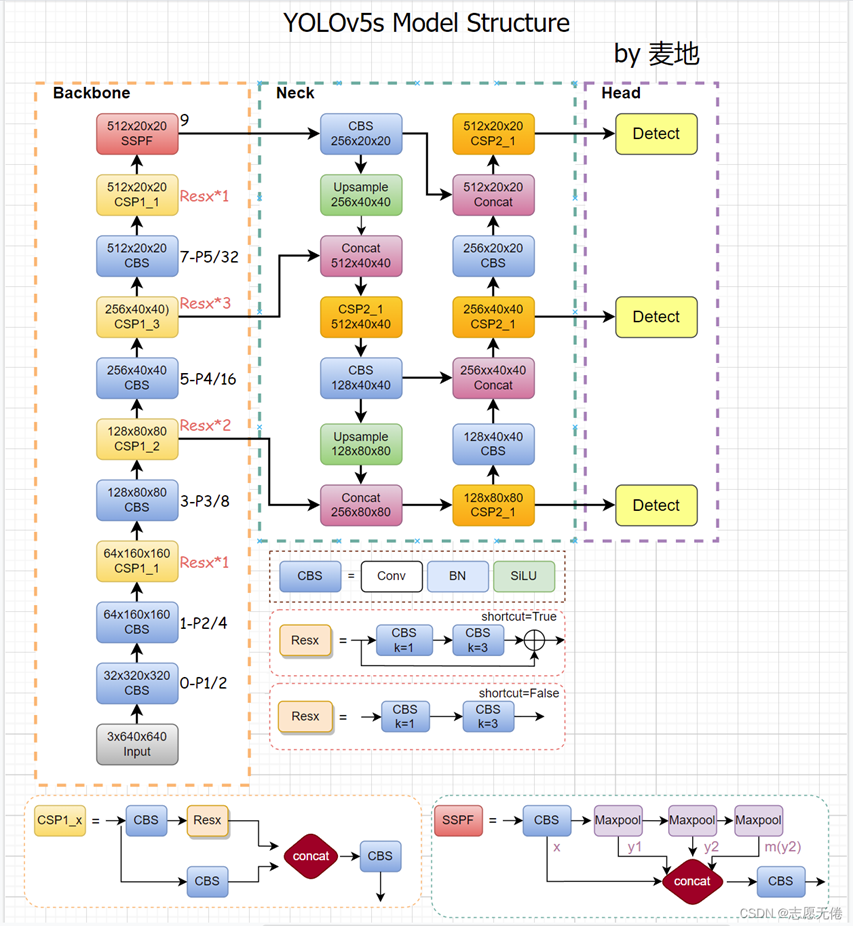

$HW_{new} = \frac{HW_{old}+2\times{padding}-((kernel\_{}size-1)\times{dilation}+1-stride)}{stride}$  
令$HW_{new} = \frac{HW_{old}}{stride}$，  
即$padding = \frac{(kernel\_{}size-1)\times{dilation}+1-stride}{2}$  
yolov5里的计算是错误的，只是负负得正，凑巧结果对了。。  
pytroch中如果卷积核滑到最后超出了特征图的边界，则不计算

In [ ]:
def autopad(kernel_size, padding=None, dilation=1):
    #
    if isinstance(kernel_size, int):
        kernel_size = dilation * (kernel_size-1) + 1
    #
    else:
        kernel_size = [dilation * (x-1) + 1 for x in kernel_size] 
    #
    if padding is None: 
        #
        if isinstance(kernel_size, int):
            padding = kernel_size // 2 
        #
        else:
            padding = [x // 2 for x in kernel_size]
    return padding 

In [ ]:
class Conv(nn.Module):
    #
    default_act = nn.SiLU()
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=None, dilation=1, groups=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, autopad(kernel_size,padding,dilation), dilation, groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        if act is True:
            self.act = self.default_act 
        elif isinstance(act, nn.Module):
            self.act = act 
        else:
            self.act = nn.Identity()
    #
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))
    #
    def forward_fuse(self, x):
        return self.act(self.conv(x))

In [ ]:
class Bottleneck(nn.Module):
    #
    def __init__(self, in_channels, out_channels, groups=1, expansion=0.5, shortcut=True):
        super().__init__()
        mid_channels = int(out_channels * expansion) 
        self.conv1 = Conv(in_channels, mid_channels, 1, 1) 
        self.conv2 = Conv(mid_channels, out_channels, 3, 1, groups=groups) 
        self.add = shortcut and in_channels==out_channels 
    #
    def forward(self, x):
        y = self.conv2(self.conv1(x))
        if self.add:
            y += x 
        return y 

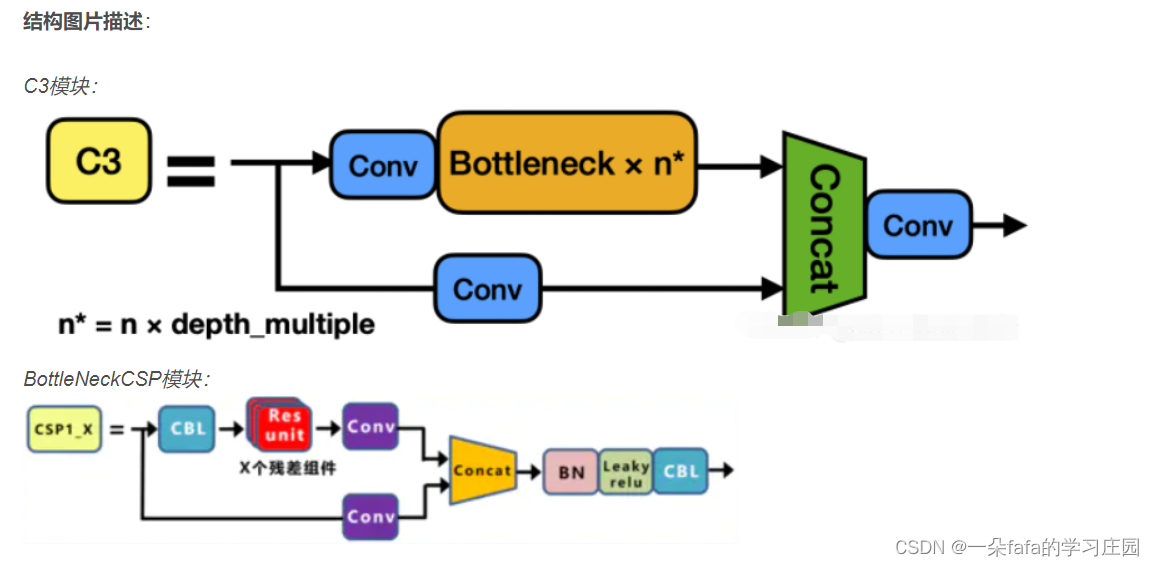

In [ ]:
class C3(nn.Module):
    #
    def __init__(self, in_channels, out_channels, groups=1, expansion=0.5, shortcut=True, num_bottleneck=1):
        super().__init__()
        mid_channels = int(out_channels * expansion) 
        self.conv1 = Conv(in_channels, mid_channels, 1, 1) 
        self.conv2 = Conv(in_channels, mid_channels, 1, 1) 
        self.conv3 = Conv(2*mid_channels, out_channels, 1, 1) 
        self.bottlenecks = nn.Sequential(*[Bottleneck(mid_channels, mid_channels, groups, 1.0, shortcut) for _ in range(num_bottleneck)]) 
    #
    def forward(self, x):
        y1 = self.bottlenecks(self.conv1(x)) 
        y2 = self.conv2(x) 
        y = T.cat([y1, y2], 1) 
        return self.conv3(y)

In [ ]:
class SPPF(nn.Module):
    #
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        mid_channels = in_channels // 2 
        self.conv1 = Conv(in_channels, mid_channels, 1, 1) 
        self.conv2 = Conv(4*mid_channels, out_channels, 1, 1) 
        self.pool = nn.MaxPool2d(kernel_size, stride=1, padding=kernel_size//2) 
    #
    def forward(self, x):
        x = self.conv1(x) 
        y1 = self.pool(x) 
        y2 = self.pool(y1) 
        y3 = self.pool(y2) 
        y = T.cat([x, y1, y2, y3], 1) 
        return self.conv2(y)

In [ ]:
class Backbone(nn.Module):
    #
    def __init__(self, ):
        super().__init__()
        self.layers = nn.ModuleList([Conv(3, 32, 6, 2, 2)])
        nums_bottleneck = [1, 2, 3, 1]
        for i in range(4):
            self.layers.append(Conv(32*2**i, 32*2**(i+1), 3, 2))
            self.layers.append(C3(32*2**(i+1), 32*2**(i+1), num_bottleneck=nums_bottleneck[i]))
        self.layers.append(SPPF(512, 512, 5))
    #
    def forward(self, x):
        outputs = []
        for i, layer in enumerate(self.layers):
            x = layer(x) 
            if i==4 or i==6 or i==8:
                outputs.append(x)
        return outputs

In [ ]:
class Concat(nn.Module):
    #
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension 
    #
    def forward(self, x):
        return T.cat(x, self.d)

In [ ]:
class CUCC(nn.Module):
    #
    def __init__(self, in_channels1, out_channels1, kernel_size, stride, in_channels2, out_channels2, up=False):
        super().__init__()
        self.conv = Conv(in_channels1, out_channels1, kernel_size, stride)
        self.up = up
        if up:
            self.upsample = nn.Upsample(None, 2, 'nearest')
        self.c3 = C3(in_channels2, out_channels2, shortcut=False)
    #
    def forward(self, x1, x2):
        outputs = []
        x = self.conv(x1)
        if self.up:
            outputs.append(x)
            x = self.upsample(x)
        else:
            outputs.append([])
        x = T.cat([x, x2], 1)
        outputs.append(self.c3(x))
        return outputs 

In [ ]:
class Neck(nn.Module):
    #
    def __init__(self, ):
        super().__init__()
        self.cucc1 = CUCC(512, 256, 1, 1, 512, 256, True)
        self.cucc2 = CUCC(256, 128, 1, 1, 256, 128, True)
        self.cucc3 = CUCC(128, 128, 3, 2, 256, 256)
        self.cucc4 = CUCC(256, 256, 3, 2, 512, 512)
    #
    def forward(self, x1, x2, x3):
        y11, y12 = self.cucc1(x3, x2) 
        y21, y22 = self.cucc2(y12, x1) 
        _, y32 = self.cucc3(y22, y21) 
        _, y42 = self.cucc4(y32, y11)
        return [y22, y32, y42]

In [ ]:
class Head(nn.Module):
    #
    def __init__(self, num_class):
        super().__init__()
        self.layers = nn.ModuleList([])
        for i in range(3):
            self.layers.append(nn.Conv2d(128*2**i, (num_class+5)*3, 1, 1))
    #
    def forward(self, x):
        outputs = []
        for i in range(3):
            outputs.append(self.layers[i](x[i]))
        return outputs

In [ ]:
def make_divisible(x, divisor):
    # Returns nearest x divisible by divisor
    if isinstance(divisor, torch.Tensor):
        divisor = int(divisor.max())  # to int
    return math.ceil(x / divisor) * divisor

In [ ]:
def parse_model(d, ch):  # model_dict, input_channels(3)
    # Parse a YOLOv5 model.yaml dictionary
    LOGGER.info(f"\n{'':>3}{'from':>18}{'n':>3}{'params':>10}  {'module':<40}{'arguments':<30}")
    anchors, nc, gd, gw, act = d['anchors'], d['nc'], d['depth_multiple'], d['width_multiple'], d.get('activation')
    if act:
        Conv.default_act = eval(act)  # redefine default activation, i.e. Conv.default_act = nn.SiLU()
        LOGGER.info(f"{colorstr('activation:')} {act}")  # print
    na = (len(anchors[0]) // 2) if isinstance(anchors, list) else anchors  # number of anchors
    no = na * (nc + 5)  # number of outputs = anchors * (classes + 5)

    layers, save, c2 = [], [], ch[-1]  # layers, savelist, ch out
    for i, (f, n, m, args) in enumerate(d['backbone'] + d['head']):  # from, number, module, args
        m = eval(m) if isinstance(m, str) else m  # eval strings
        for j, a in enumerate(args):
            with contextlib.suppress(NameError):
                args[j] = eval(a) if isinstance(a, str) else a  # eval strings

        n = n_ = max(round(n * gd), 1) if n > 1 else n  # depth gain
        if m in {
                Conv, GhostConv, Bottleneck, GhostBottleneck, SPP, SPPF, DWConv, MixConv2d, Focus, CrossConv,
                BottleneckCSP, C3, C3TR, C3SPP, C3Ghost, nn.ConvTranspose2d, DWConvTranspose2d, C3x}:
            c1, c2 = ch[f], args[0]
            if c2 != no:  # if not output
                c2 = make_divisible(c2 * gw, 8)

            args = [c1, c2, *args[1:]]
            if m in {BottleneckCSP, C3, C3TR, C3Ghost, C3x}:
                args.insert(2, n)  # number of repeats
                n = 1
        elif m is nn.BatchNorm2d:
            args = [ch[f]]
        elif m is Concat:
            c2 = sum(ch[x] for x in f)
        # TODO: channel, gw, gd
        elif m in {Detect, Segment}:
            args.append([ch[x] for x in f])
            if isinstance(args[1], int):  # number of anchors
                args[1] = [list(range(args[1] * 2))] * len(f)
            if m is Segment:
                args[3] = make_divisible(args[3] * gw, 8)
        elif m is Contract:
            c2 = ch[f] * args[0] ** 2
        elif m is Expand:
            c2 = ch[f] // args[0] ** 2
        else:
            c2 = ch[f]

        m_ = nn.Sequential(*(m(*args) for _ in range(n))) if n > 1 else m(*args)  # module
        t = str(m)[8:-2].replace('__main__.', '')  # module type
        np = sum(x.numel() for x in m_.parameters())  # number params
        m_.i, m_.f, m_.type, m_.np = i, f, t, np  # attach index, 'from' index, type, number params
        LOGGER.info(f'{i:>3}{str(f):>18}{n_:>3}{np:10.0f}  {t:<40}{str(args):<30}')  # print
        save.extend(x % i for x in ([f] if isinstance(f, int) else f) if x != -1)  # append to savelist
        layers.append(m_)
        if i == 0:
            ch = []
        ch.append(c2)
    return nn.Sequential(*layers), sorted(save)

In [ ]:
class YOLOv5(nn.Module):
    #
    def __init__(self, num_anchor=num_anchor, num_class=num_class, stride=stride, training=True):
        super().__init__()
        self.backbone = Backbone()
        self.neck = Neck()
        self.head = Head(num_class) 
        self.grid = [torch.empty(0) for _ in range(3)] 
        self.anchor_grid = [torch.empty(0) for _ in range(3)] 
        self.num_anchor = num_anchor 
        self.num_class = num_class 
        self.stride = stride
        self.training = training 
    #
    def forward(self, x):
        # 
        x1, x2, x3 = self.backbone(x) 
        x1, x2, x3 = self.neck(x1, x2, x3) 
        x = self.head([x1, x2, x3])
        z = []
        for i in range(len(x)):
            b, _, h, w = x[i].shape
            x[i] = x[i].reshape([b, self.num_anchor, self.num_class+5, h, w]).permute(0, 1, 3, 4, 2)
            if not self.training:
                self.grid[i], self.anchor_grid[i] = self._make_grid(w, h, i)
                xy, wh, conf = x[i].sigmoid().split((2, 2, self.num_class + 1), 4)
                xy = (xy * 2 + self.grid[i]) * self.stride[i]
                wh = (wh * 2) ** 2 * self.anchor_grid[i]
                y = torch.cat((xy, wh, conf), 4)
                z.append(y.view(b, self.num_anchor * w * h, self.num_class+5))
        if self.training:
            return x 
        else:
            return T.cat(z, 1)
    #
    def _make_grid(self, nx=20, ny=20, i=0):
        shape = 1, self.num_anchor, ny, nx, 2  # grid shape
        y, x = torch.arange(ny, device=device, dtype=T.float32), torch.arange(nx, device=device, dtype=T.float32)
        yv, xv = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((xv, yv), 2).expand(shape) - 0.5  # add grid offset, i.e. y = 2.0 * x - 0.5
        anchor_grid = (anchors[i] * self.stride[i]).view((1, self.num_anchor, 1, 1, 2)).expand(shape)
        return grid, anchor_grid

In [ ]:
x = T.randn([2, 3, 640, 640], device=device) 
net = YOLOv5().to(device) 
net.training = True
# net.training = False
y = net(x) 
if net.training:
    print(len(y)) 
    print(y[0].shape)
    print(y[1].shape)
    print(y[2].shape)
else:
    print(y.shape)

# Show 

In [ ]:
def box_iou(box1, box2, eps=1e-7): 
    a1, a2 = box1.unsqueeze(1).chunk(2, 2) 
    b1, b2 = box2.unsqueeze(0).chunk(2, 2) 
    intersection = (T.min(a2, b2) - T.max(a1,b1)).clamp(0).prod(2) 
    union = (a2 - a1).prod(2) + (b2 - b1).prod(2) - intersection 
    return intersection / (union + eps) 

In [ ]:
def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output

In [ ]:
@T.no_grad()
def show(net=None):
    #
    if net is None:
        net = YOLOv5().to(device)
    net.eval()
    net.training = False
    #
    dataloader = DataLoader(LoadImagesAndLabels(), shuffle=True, num_workers=num_workers, collate_fn=LoadImagesAndLabels.collate_fn)
    n = 0
    for image, label in dataloader:
        #
        pred = net(image.clone().to(device))
        image = np.ascontiguousarray(image.squeeze().numpy().transpose([1,2,0]) * 0.5 + 0.5)
        image2 = image.copy()
        label[...,2:] = xywh2xyxy(label[...,2:])
        label[...,2:] *= image_size
        targets = label.numpy().round().astype('int')
        pred = non_max_suppression(pred)
        pred = pred[0]
        box = pred[..., :4]
        category = pred[..., 5:]
        box = box.cpu().detach().numpy().round().astype('int')
        category = category.cpu().detach().numpy().astype('int')
        #
        for i in range(targets.shape[0]):
            cv2.rectangle(image, targets[i,2:4]-5, targets[i,4:6]+5, [0,1,0], 1)
            # cv2.putText(image, str(id2name[targets[i,1]]), targets[i,2:4], cv2.FONT_HERSHEY_SIMPLEX, 2, [0,1,0], 2, cv2.LINE_AA)
        plt.figure(figsize=(30,30))
        plt.subplot(1,2,1)
        plt.imshow(image)
        #
        for i in range(pred.shape[0]):
            cv2.rectangle(image2, box[i,0:2]-5, box[i,2:4]+5, [0,1,0], 1)
            # cv2.putText(image2, str(id2name[category[i,0]]), box[i,0:2], cv2.FONT_HERSHEY_SIMPLEX, 2, [0,1,0], 2, cv2.LINE_AA)
        plt.subplot(1,2,2)
        plt.imshow(image2)
        plt.show()
        #
        break
    net.training = True

In [ ]:
show()

# Train 

In [ ]:
def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, (b1_y2 - b1_y1).clamp(eps)
        w2, h2 = b2_x2 - b2_x1, (b2_y2 - b2_y1).clamp(eps)

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU

In [ ]:
def smooth_BCE(eps=0.1):  # https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441
    # return positive, negative label smoothing BCE targets
    return 1.0 - 0.5 * eps, 0.5 * eps

In [ ]:
class FocalLoss(nn.Module):
    # Wraps focal loss around existing loss_fcn(), i.e. criteria = FocalLoss(nn.BCEWithLogitsLoss(), gamma=1.5)
    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = 'none'  # required to apply FL to each element

    def forward(self, pred, true):
        loss = self.loss_fcn(pred, true)
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = torch.sigmoid(pred)  # prob from logits
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

In [ ]:
class ComputeLoss:
    sort_obj_iou = False

    # Compute losses
    def __init__(self, autobalance=False, device=device):
        # Define criteria
        BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([cls_pw], device=device))
        BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([obj_pw], device=device))

        # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
        self.cp, self.cn = smooth_BCE(label_smoothing)  # positive, negative BCE targets

        # Focal loss
        g = fl_gamma  # focal loss gamma
        if g > 0:
            BCEcls, BCEobj = FocalLoss(BCEcls, g), FocalLoss(BCEobj, g)

        self.balance = {3: [4.0, 1.0, 0.4]}.get(3, [4.0, 1.0, 0.25, 0.06, 0.02])  # P3-P7
        self.ssi = list(stride).index(16) if autobalance else 0  # stride 16 index
        self.BCEcls, self.BCEobj, self.gr, self.autobalance = BCEcls, BCEobj, 1.0, autobalance
        self.na = num_anchor  # number of anchors
        self.nc = num_class  # number of classes
        self.nl = 3  # number of layers
        self.anchors = anchors
        self.device = device

    def __call__(self, p, targets):  # predictions, targets
        # print(len(p), len(targets))
        # print(p[0].shape, p[1].shape, p[2].shape, targets.shape)
        # print(targets)
        lcls = torch.zeros(1, device=self.device)  # class loss
        lbox = torch.zeros(1, device=self.device)  # box loss
        lobj = torch.zeros(1, device=self.device)  # object loss
        tcls, tbox, indices, anchors = self.build_targets(p, targets)  # targets
        # exit()

        # Losses
        for i, pi in enumerate(p):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
            tobj = torch.zeros(pi.shape[:4], dtype=pi.dtype, device=self.device)  # target obj

            n = b.shape[0]  # number of targets
            if n:
                # pxy, pwh, _, pcls = pi[b, a, gj, gi].tensor_split((2, 4, 5), dim=1)  # faster, requires torch 1.8.0
                pxy, pwh, _, pcls = pi[b, a, gj, gi].split((2, 2, 1, self.nc), 1)  # target-subset of predictions

                # Regression
                pxy = pxy.sigmoid() * 2 - 0.5
                pwh = (pwh.sigmoid() * 2) ** 2 * anchors[i]
                pbox = torch.cat((pxy, pwh), 1)  # predicted box
                iou = bbox_iou(pbox, tbox[i], CIoU=True).squeeze()  # iou(prediction, target)
                lbox += (1.0 - iou).mean()  # iou loss

                # Objectness
                iou = iou.detach().clamp(0).type(tobj.dtype)
                if self.sort_obj_iou:
                    j = iou.argsort()
                    b, a, gj, gi, iou = b[j], a[j], gj[j], gi[j], iou[j]
                if self.gr < 1:
                    iou = (1.0 - self.gr) + self.gr * iou
                tobj[b, a, gj, gi] = iou  # iou ratio

                # Classification
                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = torch.full_like(pcls, self.cn, device=self.device)  # targets
                    t[range(n), tcls[i]] = self.cp
                    lcls += self.BCEcls(pcls, t)  # BCE

                # Append targets to text file
                # with open('targets.txt', 'a') as file:
                #     [file.write('%11.5g ' * 4 % tuple(x) + '\n') for x in torch.cat((txy[i], twh[i]), 1)]

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]  # obj loss
            if self.autobalance:
                self.balance[i] = self.balance[i] * 0.9999 + 0.0001 / obji.detach().item()

        if self.autobalance:
            self.balance = [x / self.balance[self.ssi] for x in self.balance]
        lbox *= box
        lobj *= obj
        lcls *= cls
        bs = tobj.shape[0]  # batch size

        return (lbox + lobj + lcls) * bs, torch.cat((lbox, lobj, lcls)).detach()

    def build_targets(self, p, targets):
        # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
        na, nt = self.na, targets.shape[0]  # number of anchors, targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=self.device)  # normalized to gridspace gain
        ai = torch.arange(na, device=self.device).float().view(na, 1).repeat(1, nt)  # same as .repeat_interleave(nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[..., None]), 2)  # append anchor indices
        # print(targets)

        g = 0.5  # bias
        off = torch.tensor(
            [
                [0, 0],
                [1, 0],
                [0, 1],
                [-1, 0],
                [0, -1],  # j,k,l,m
                # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
            ],
            device=self.device).float() * g  # offsets

        for i in range(self.nl):
            anchors, shape = self.anchors[i], p[i].shape
            gain[2:6] = torch.tensor(shape)[[3, 2, 3, 2]]  # xyxy gain

            # Match targets to anchors
            t = targets * gain  # shape(3,n,7)
            if nt:
                # Matches
                r = t[..., 4:6] / anchors[:, None]  # wh ratio
                j = torch.max(r, 1 / r).max(2)[0] < anchor_t  # compare
                # j = wh_iou(anchors, t[:, 4:6]) > model.hyp['iou_t']  # iou(3,n)=wh_iou(anchors(3,2), gwh(n,2))
                t = t[j]  # filter

                # Offsets
                gxy = t[:, 2:4]  # grid xy
                gxi = gain[[2, 3]] - gxy  # inverse
                j, k = ((gxy % 1 < g) & (gxy > 1)).T
                l, m = ((gxi % 1 < g) & (gxi > 1)).T
                j = torch.stack((torch.ones_like(j), j, k, l, m))
                t = t.repeat((5, 1, 1))[j]
                offsets = (torch.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                t = targets[0]
                offsets = 0

            # Define
            bc, gxy, gwh, a = t.chunk(4, 1)  # (image, class), grid xy, grid wh, anchors
            a, (b, c) = a.long().view(-1), bc.long().T  # anchors, image, class
            gij = (gxy - offsets).long()
            gi, gj = gij.T  # grid indices

            # Append
            indices.append((b, a, gj.clamp_(0, shape[2] - 1), gi.clamp_(0, shape[3] - 1)))  # image, anchor, grid
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
            anch.append(anchors[a])  # anchors
            tcls.append(c)  # class

        return tcls, tbox, indices, anch

In [ ]:
def trainer(net, optimizer, compute_loss, image, label):
    #
    pred = net(image)
    #
    loss, _ = compute_loss(pred, label)
    #
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def train(batch_size, epochs, load_model):
    #
    net = YOLOv5().to(device)
    net.train()
    compute_loss = ComputeLoss()
    optimizer = T.optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.9,0.999))
    if load_model:
        net.load_state_dict(T.load(path_work + 'net.pt'))
        optimizer.load_state_dict(T.load(path_work + 'optimizer.pt'))
        with open(path_work + 'epoch.txt') as f:
            epoch_start = int(f.read())
    else:
        epoch_start = -1
    #
    ticks = time.time()
    iteration = 0
    for epoch in range(epoch_start+1, epochs):
        # dataloader = DataLoader(LoadImagesAndLabels(epoch=epoch), batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=LoadImagesAndLabels.collate_fn)
        dataloader = DataLoader(LoadImagesAndLabels(), batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=LoadImagesAndLabels.collate_fn)
        for image, label in dataloader:
            trainer(net, optimizer, compute_loss, image.to(device), label.to(device))
            iteration += 1
    #
        if epoch % 1000 == 0:
            print('Epoch: ', epoch, ', Iteration: ', iteration)
            T.save(net.state_dict(), path_work + 'net.pt')
            T.save(optimizer.state_dict(), path_work + 'optimizer.pt')
            with open(path_work + 'epoch.txt', 'w') as f:
                f.write(str(epoch))
            show(net)
            net.train()
            print('Time cost: ', time.time()-ticks, 's')
            ticks = time.time()

In [ ]:
# train(batch_size=batch_size, epochs=1, load_model=False)

Epoch:  9000 , Iteration:  8920


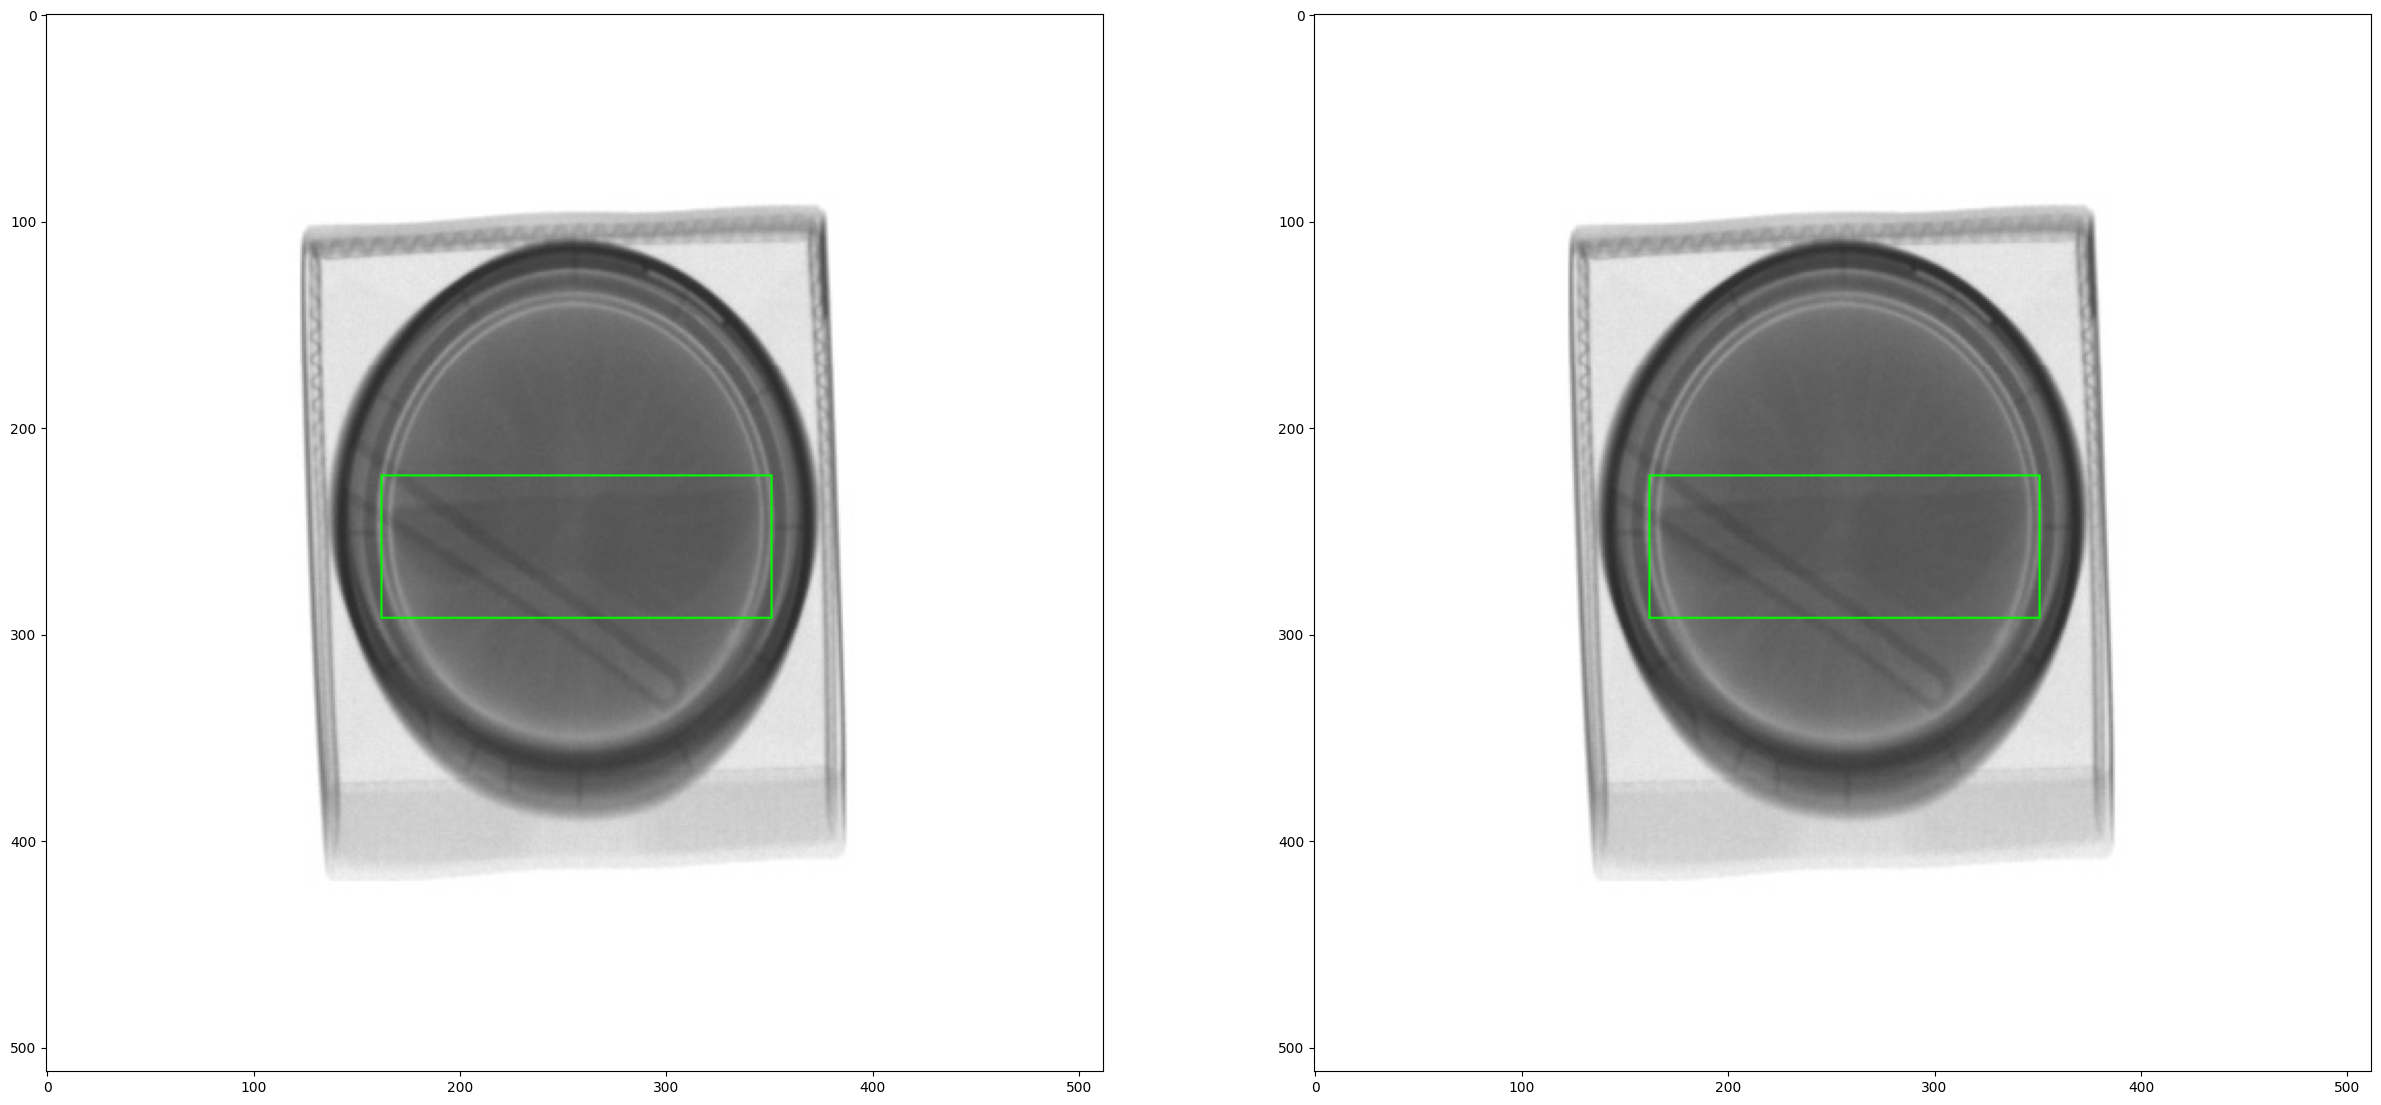

Time cost:  41.43964910507202 s


In [36]:
train(batch_size=batch_size, epochs=epochs, load_model=True)

# Test

In [ ]:
net = YOLOv5().to(device)
net.load_state_dict(T.load(path_work + 'net.pt'))
show(net)